# Matching Gaia quasars to AllWISE

This tutorial shows how to match quasars present in the Gaia DR1 all source catalog to AllWISE catalog of Mid-IR AGNs. The AllWISE sample is available for download at VizieR: http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/ApJS/221/12, with a short description here: https://heasarc.gsfc.nasa.gov/W3Browse/all/allwiseagn.html.

Gaia DR1 has a quasar table, however, the astrometric solution there is not the same as in the all source catalog. The differences between quasar positions in the two solutions are in general small (on the order of a few mas), however, there are some objects where discrepancies are more severe. In this tutorial, we consider Gaia quasars from the all source catalog, and identify them using the quasar table.

We first set up the environment:

In [3]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u

%matplotlib inline

Next, we'll define a function to query the Gaia DR1 all source table. This is a modified version of the example available on the Gaia archive.

In [2]:
import httplib
import urllib
import time
from xml.dom.minidom import parseString

host = "gea.esac.esa.int"
port = 80
pathinfo = "/tap-server/tap/async"

def acall(query, fout, fmt="csv", verbose=False):
    """
    ASYNCHRONOUS REQUEST
    Parameters:
    query - string containing an ADQL query to perform
    fout - path to output file
    fmt - format for the resulting data file (default: csv)
    verbose - boolean, if True, progress is reported
    """
    
    # Query
    params = urllib.urlencode({\
        "REQUEST": "doQuery", \
        "LANG":    "ADQL", \
        "FORMAT":  fmt, \
        "PHASE":  "RUN", \
        "QUERY":   query
        })

    headers = {\
        "Content-type": "application/x-www-form-urlencoded", \
        "Accept":       "text/plain" \
        }

    connection = httplib.HTTPConnection(host, port)
    connection.request("POST",pathinfo,params,headers)

    # Status
    response = connection.getresponse()
    if verbose: print("Status: " +str(response.status), "Reason: " + str(response.reason))

    # Server job location (URL)
    location = response.getheader("location")
    if verbose: print("Location: " + location)

    #Jobid
    jobid = location[location.rfind('/')+1:]
    if verbose: print("Job id: " + jobid)

    connection.close()

    #-------------------------------------
    #Check job status, wait until finished

    while True:
        connection = httplib.HTTPConnection(host, port)
        connection.request("GET",pathinfo+"/"+jobid)
        response = connection.getresponse()
        data = response.read()
        #XML response: parse it to obtain the current status
        dom = parseString(data)
        phaseElement = dom.getElementsByTagName('uws:phase')[0]
        phaseValueElement = phaseElement.firstChild
        phase = phaseValueElement.toxml()
        if verbose: print("Status: " + phase)
        #Check finished
        if phase == 'COMPLETED': break
        #wait and repeat
        time.sleep(0.2)

    connection.close()

    #-------------------------------------
    #Get results
    connection = httplib.HTTPConnection(host, port)
    connection.request("GET",pathinfo+"/"+jobid+"/results/result")
    response = connection.getresponse()
    data = response.read()
    outputFileName = fout
    outputFile = open(outputFileName, "w")
    outputFile.write(data)
    outputFile.close()
    connection.close()
    if verbose: print("Data saved in: " + outputFileName)

We are now ready to download quasar rows from the all source table in Gaia DR1 `gaiadr1.gaia_source`. We first obtain the list of quasar ids from the `gaiadr1.gaia_qso` table (here downloaded as `qso.fits`). Then we query the all source table, with a condition that `source_id` is one of the identified quasar ids. Once the query is constructed, we use the call function defined above, and ultimately store the data as an `astropy.table` in fits format.

In [ ]:
gq = Table.read('../data/qso.fits')

qso_ids = ', '.join(map(str,np.array(gq['source_id']).tolist()[:]))
query = """SELECT * FROM gaiadr1.gaia_source WHERE source_id IN ({}) ORDER BY gaiadr1.gaia_source.ra""".format(qso_ids)
fout = "../data/gaia_qso.csv"

acall(query, fout, verbose=True)

# save table in fits format
t = Table.read(fout, format='csv')
t.write('../data/gaia_qso.fits', overwrite=True)

Now we have two catalogs: `gaia_qso.fits` with Gaia quasars, and `allwise_agn.fits` with AllWISE quasars. We define two astropy ICRS catalogs, the reference one based on AllWISE and the one we'd like to match based on Gaia. Then we simply use `astropy.coordinates` function `match_coordinates_sky` to match the two.

In [6]:
g = Table.read('../data/gaia_qso.fits')
w = Table.read('../data/allwise_agn.fits')

# match sources
ref = coord.ICRS(coord.Angle(w['RAJ2000']), coord.Angle(w['DEJ2000']))
cat = coord.ICRS(coord.Angle(g['ra']*u.deg), coord.Angle(g['dec']*u.deg))
id1, d21, d31 = coord.match_coordinates_sky(cat, ref)

The separation from the closest AllWISE source is given in the array d21, and the id of the source in id1. The distribution of closest matches is peaked at $<1\,\rm arcsec$, with $\sim60\%$ of Gaia sources having a match within $0.2\,\rm arcsec$.

59% sources with matches within 0.2 arcsec


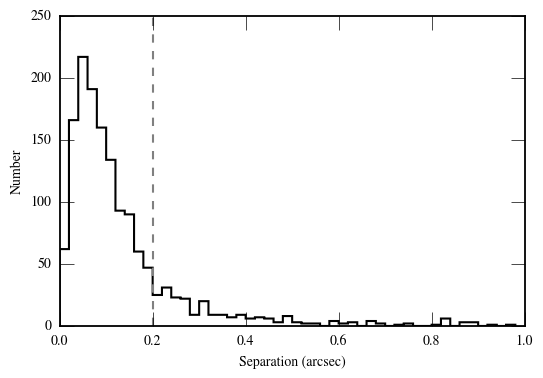

In [15]:
dr = 0.2*u.arcsec
print('{:.0f}% sources with matches within {}'.format(np.sum(d21<dr)/np.size(d21)*100, dr))

plt.hist(d21.to(u.arcsec), bins=np.arange(0,1,0.02), color='k', histtype='step', lw=1.5)
plt.axvline(dr.to(u.arcsec).value, ls='--', color='0.5', lw=1.5)

plt.xlabel('Separation (arcsec)');
plt.ylabel('Number');

Adopting $0.2\,\rm arcsec$ as the matching distance, we are left with 1220 Gaia sources matched to AllWISE AGN, uniformly distributed on the sky.

1220 matched sources


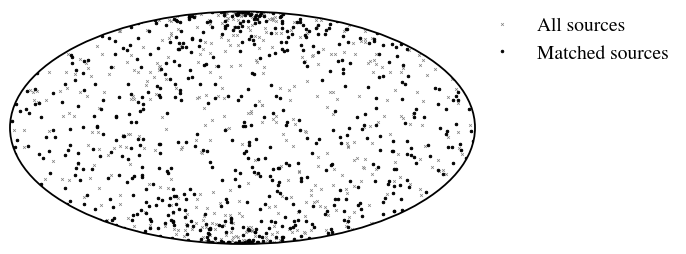

In [24]:
# sources in common
ind = d21.value<dr.to(u.deg).value
print('{} matched sources'.format(np.sum(ind)))

plt.subplot(111, projection='hammer')
plt.plot(g['ra'], g['dec'], 'x', mec='0.5', ms=2, label='All sources')
plt.plot(w[id1[ind]]['RAJ2000'], w[id1[ind]]['DEJ2000'], 'ko', ms=2, label='Matched sources')
plt.legend(frameon=False, numpoints=1, fontsize=14, loc=[1,0.75])
plt.setp(plt.gca().get_xticklabels(), visible=False);
plt.setp(plt.gca().get_yticklabels(), visible=False);